# implementing Optimization iteration

In [91]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
%matplotlib inline
''' %matplotlib inline sets the backend of matplotlib to
the 'inline' backend. When using the 'inline' backend,
your matplotlib graphs will be included in your notebook,
next to the code.'''

" %matplotlib inline sets the backend of matplotlib to\nthe 'inline' backend. When using the 'inline' backend,\nyour matplotlib graphs will be included in your notebook,\nnext to the code."

# Make up a dataset

(100, 2)

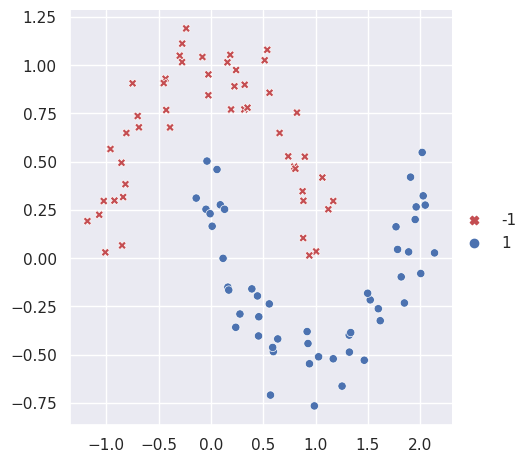

In [92]:
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples = 100, noise=0.1)
# print(y)
# print(X)
y = 2*y - 1 # make y be -1 or 1
# visualize in 2D
sns.relplot(x=X[:,0], y=X[:,1], hue=y, style=y, palette=['r', 'b'], markers=['X', 'o'])
X.shape

## A NN that subscribes to the PyTorch api

In [93]:
# we have our class Value
class Value:
    
    def __init__(self, data, _prev=(), _op='', label=''):
        self.data = data
        self._prev = set(_prev) # the order does not matter, use set instead of list
        self._op = _op
        self.label = label

        self.grad = 0.0

        # After the forwrd path (when we have the data vlaue of all nodes)
        # we start the backprop (to get the gradients for each node)
        # the output node of each operation knows the operation and children
        # since we dont have a backprop for leaf nodes, and 
        # each operation has different local gradient
        # we can't define a general method in the class.
        # so at the time of doing the operation,
        # we can both define the local gradiant function
        # and store the whole chain rule function in an attribute to call later.
        # then call the local this function attribute from end node to the begining.
        self._backprop = lambda: None
    
    def __repr__(self) -> str:
        return f'Value({self.label} | data:{self.data} | grad:{self.grad})'
    
    def __add__(self, other):
        # check if 'other' is an instance of 'Value'
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data + other.data, (self, other), _op='+')
        
        def _backprop():
            # partial derivatives for each input:
            self.grad += out.grad
            other.grad += out.grad

        out._backprop = _backprop
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __sub__(self, other):
        return self + -1*other
    
    def __rsub__(self, other):
        return -1*(self + -1*other)
    
    def __neg__(self):
        return self * -1

    def __mul__(self, other):
        # check if 'other' is an instance of 'Value'
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data * other.data, (self, other), _op='*')
        
        def _backprop():
            # partial derivatives for each input:
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backprop = _backprop
        return out
    
    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1
    
    def __rtruediv__(self, other):
        return other * self**-1
    
    def __pow__(self, other):
        # only support int or float powers for now!!
        # in case of other of type 'Value', we would need another method
        assert isinstance(other, (int, float))
        
        out = Value(self.data**other, (self,), _op=f'**{other}')

        def _backprop():
            self.grad += (other * self.data**(other - 1)) * out.grad
        
        out._backprop = _backprop
        return out

    def relu(self):
        out = Value( self.data if self.data > 0.0 else 0.0 , (self,), _op='ReLU' )
        
        def _backprop():
            self.grad += out.grad * (out.data > 0.0)
        
        out._backprop = _backprop
        return out
    
    def exp(self):
        out = Value(np.exp(self.data), (self,), _op='exp')
        
        def _backprop():
            self.grad += out.data * out.grad
        
        out._backprop = _backprop
        return out
    
    def tanh(self):
        tanh = (np.exp(2*self.data) - 1)/(np.exp(2*self.data) + 1)
        out = Value( tanh, (self,), _op='tanh')
        
        def _backprop():
            self.grad += (1 - tanh**2) * out.grad
        
        out._backprop = _backprop
        return out
    
    def backprop(self):
        topo_sort_list = []
        visited = set() # the order does not matter, use set instead of list
        
        def build_topo(root):
            if root not in visited:
                visited.add(root)
                # Appending to topo_sort before its children are processed
                # will give us out-to-left sort,
                # but not out to leaf sort in case of b (bias leaf), try it & see it
                for child in root._prev:
                    build_topo(child)
                # Appending after its children are processed
                # will give us leaf-to-out sort
                topo_sort_list.append(root)
        
        build_topo(root=self)
        
        self.grad = 1.0
        for node in reversed(topo_sort_list):
            node._backprop()


## MLP
1) make it more like PyTorch:

    1.1) A parent class for zero_grad & parameters
    
    1.2) Adding linearity & Non-linearity to Neurons
    
    1.3) a repr for onjects

In [94]:
class Module:
    def parameters(self):
        return []
    
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0.0


class Neuron(Module):
    # nin: number of inputs
    def __init__(self, nin: int, act_func=None):
        self.w = [ Value( random.uniform(-1,1), label=f'w{i}' ) for i in range(nin)]
        self.b = Value(random.uniform(-1,1), label='b')
        self.act_func = act_func
    
    def __call__(self, x: list) -> float:
        # w * x + b -> a scalar value
        activation = sum( ( wi*xi for wi,xi in zip(self.w, x) ) , start=self.b) # pair up w & x point wise
        return activation if self.act_func is None else activation.tanh() # getattr(activation, self.act_func)()
    
    def parameters(self):
        return self.w + [self.b]
    
    def __repr__(self) -> str:
        return f"{'Linear' if self.act_func is None else self.act_func} Neuron({len(self.w)})"


class OneMLPLayer(Module):

    def __init__(self, nin: int, nout: int, **kwargs):
        '''
        so we need a bunch of Neurons:
        Data structure? -> order matters -> list
        '''
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]
    
    def __call__(self, x: list) -> list:
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self) -> list:
        # list comprehension with double for:
        # write the for loops in a way you write it as usual !! 
        return [parameter for neuron in self.neurons for parameter in neuron.parameters()]
    
    def __repr__(self) -> str:
        return f"Layer of [{', '.join( str(n) for n in self.neurons)}]"


class MLP(Module):
    '''
    we want a bunch of layers -> order matters -> list
    input layer: nin - hidden layer: hs - output layer: nout
    '''
    def __init__(self, nin: int, hs: list, nout: int, **kwargs) -> None:
        layer_width = [nin] + hs + [nout]
        self.layers = [OneMLPLayer(nin= layer_width[idx], nout=layer_width[idx+1], **kwargs) for idx in range(len(layer_width)-1) ]

    def __call__(self, x) -> list:
        out = x
        for layer in self.layers:
            out = layer(out)
        return out
    
    def parameters(self):
        return [parameter for layer in self.layers for parameter in layer.parameters()]

    def __repr__(self) -> str:
        return f" MLP of [{ ', '.join( str(l) for l in self.layers) }]"


In [95]:
model = MLP(nin=2, hs=[16, 16], nout=1, act_func='tanh')
model

 MLP of [Layer of [tanh Neuron(2), tanh Neuron(2), tanh Neuron(2), tanh Neuron(2), tanh Neuron(2), tanh Neuron(2), tanh Neuron(2), tanh Neuron(2), tanh Neuron(2), tanh Neuron(2), tanh Neuron(2), tanh Neuron(2), tanh Neuron(2), tanh Neuron(2), tanh Neuron(2), tanh Neuron(2)], Layer of [tanh Neuron(16), tanh Neuron(16), tanh Neuron(16), tanh Neuron(16), tanh Neuron(16), tanh Neuron(16), tanh Neuron(16), tanh Neuron(16), tanh Neuron(16), tanh Neuron(16), tanh Neuron(16), tanh Neuron(16), tanh Neuron(16), tanh Neuron(16), tanh Neuron(16), tanh Neuron(16)], Layer of [tanh Neuron(16)]]

## Optimization Iterations

Changes:

1- defining a loss function

In [96]:
def loss(batch_size=None, l2_coef = 1e-4, margin=1.0):
    # initialize dataloader
    if batch_size is None:
        Xb, yb = X, y
    else:
        batch_idx = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[batch_idx], y[batch_idx]
    
    '''
    use map() for creating batches on large data.
    map() takes a function object and an iterable (or multiple iterables)
    as arguments and returns an iterator that yields transformed items
    on demand
    
    1. map() is written in C and is highly optimized,
        its internal implied loop is more efficient than
        a regular Python for loop.
    
    2. With a for loop, you need to store the whole list in your system’s memory.
        With map(), you get items on demand,
        and only one item is in your system’s memory at a given time.
    '''
    # X is a Matrix, but we want Value objects of each data point's dimension:
    # xrow is a vector or list. map is an iterator, wrap it with list
    inputs = [ list(map(Value, xrow)) for xrow in Xb]

    # forward the model to get y_preds or scores -> model(inputs), use map() instead of for loop
    scores = list(map(model, inputs)) # y_preds

    # Hinge Loss or svm "max-margin" loss
    ## $$$$ very important: loss is always + , use ReLU !!!
    losses = [ (margin - yi*si).relu() for yi, si in zip(yb, scores)]
    ## in SVM we have αi (importance of data points for finding SVs)
    ## here we assume all data points are equally important
    data_loss = sum(losses)/ len(losses)

    ## in SVM we also have an L2-norm of weights as weight regularization term
    reg_loss = sum(p*p for p in model.parameters())

    ## total loss 
    total_loss = data_loss + l2_coef * reg_loss

    # also get accuracy
    ''' accuracy is about which side of the hyperplanes is the prediction
     so saying yi==si is wrong,
     we must check the sign of yi * si or as in SVM ti * w*xi'''
    # below is computationally lighter :)
    accuracy = [ (yi > 0.0) == (si.data > 0.0) for yi, si in zip(yb, scores)]
    return total_loss, sum(accuracy)/len(accuracy)

In [97]:
total_loss, acc = loss()
print(total_loss, acc)

Value( | data:1.0594960069738981 | grad:0.0) 0.5


## The power of SGD & low batch size
1. give the whole batch to the model (batch_size = None , niter=20):
    you will see that the model would not improve and even might get worse (gradients increase)

2. then give it (batch_size = 1 , niter=1000), surprise!! model does a really good jo now

3. why? it's clear, bc:
    
    In the former, we `average the loss` for all data points and compute the gradients. It's `hard to find a gradient that satisfies all data points!` i.e. gradients from different data points cancel each other, and `make the gradients low for all weights`!! so we don't move a lot from our previous position!
    
    In contrast, when we use batch_size=1, for one data point, some weights will have a high gradient and some others will have a low one. we only change those with a high one. For another sample this will happen for different set of weights. The point we change weights, we move to another position

in my experience:

    1 iteration (niter=2) with batch_size=1 and wrong classification, you will encounter more of the following:
    
        total_grad : 14.251573775690757
        
        w0's grad : 8.248696785199401e-05
    
    1 iteration with whole data:
    
        total_grad : 0.6998460422710074
        
        w0's grad : -0.014186355940754706


**don't get to excited**, we compute the `forward path in parallel` for all data in batch and average the loss.

so if we just compute it for one data point every time, `it's gonna take much longer to finish the whole dataset`!! especially when data is high dimensional.

It's a trade-off :

`energy+time+money (GPUs!!) VS usually better model`


## The importance of Tuning L2_coef & margin !!!
The larger the l2_coef, the lower the weights, the less complex model

if you want a wider margin, you need larger weights (lower l2_coef) too.

Caveat: the model might no be able to find any decision boundary for either high margin or with high weights:

    - with too high margin: it's simply impossible given the data.

    - with too high weights: as in SVM, to have the highest margin (distance) you need lower ||w|| remember!

In [89]:
# Batch Iterations
low_batch = True
if low_batch:
    niter = 2000
    batch_size = 2
else:
    niter = 2
    batch_size = None
lr = 0.05
verbose = False

for i in range(1, niter):
    ## Forward Path
    ### The larger the l2_coef, the lower the weights, the less complex model
    total_loss, acc = loss(batch_size, l2_coef = 1e-5, margin=2)

    model.zero_grad()
    total_grad = 0
    ## Backprop or Backward Path
    total_loss.backprop()

    ## Update `p_new = p_old - lr*grad`
    ### Learning rate decay
    # lr = 0.1 - i/100
    for p in model.parameters():
        p.data -= lr*p.grad
        # total_grad += p.grad
    
    print(f'iteration: {i} | loss: {total_loss.data} | accuracy: {acc*100}%')
    if verbose:
        print(f'total_grad: {total_grad} | w0: {model.layers[0].neurons[0].w[0]}\n')


iteration: 1 | loss: 1.052544328810015 | accuracy: 100.0%
iteration: 2 | loss: 1.991212494587796 | accuracy: 50.0%
iteration: 3 | loss: 2.971337159162061 | accuracy: 0.0%
iteration: 4 | loss: 1.028884868142833 | accuracy: 100.0%
iteration: 5 | loss: 2.9866534941828164 | accuracy: 0.0%
iteration: 6 | loss: 2.967778127880282 | accuracy: 0.0%
iteration: 7 | loss: 2.989880716773222 | accuracy: 0.0%
iteration: 8 | loss: 1.982462925298357 | accuracy: 50.0%
iteration: 9 | loss: 2.9867966703552855 | accuracy: 0.0%
iteration: 10 | loss: 2.9153941173621667 | accuracy: 0.0%
iteration: 11 | loss: 2.025609859152322 | accuracy: 50.0%
iteration: 12 | loss: 2.0330885072136655 | accuracy: 50.0%
iteration: 13 | loss: 2.03897536309612 | accuracy: 50.0%
iteration: 14 | loss: 2.955804629241808 | accuracy: 0.0%
iteration: 15 | loss: 1.9603532667834318 | accuracy: 50.0%
iteration: 16 | loss: 2.8739854728499172 | accuracy: 0.0%
iteration: 17 | loss: 2.0601472686598608 | accuracy: 50.0%
iteration: 18 | loss: 1

## Visualize Decision Boundaries

(-1.6404521912462298, 2.1095478087537702)

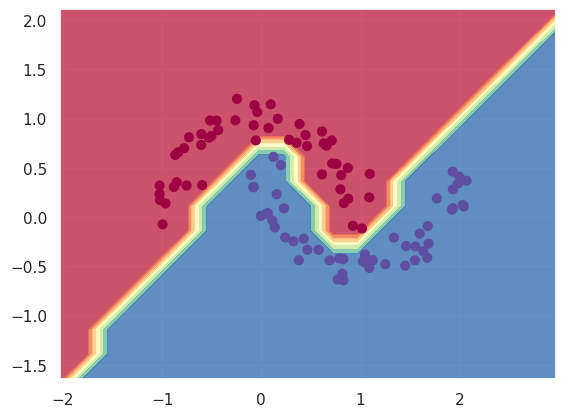

In [90]:
h = 0.25
# plot coordinates
x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# ravel: Flatten the Matrix
# c_ : pair 2 arrays, like zip for 2 list
Xmesh = np.c_[xx.ravel(), yy.ravel()]

# Give the whole mesh space to the model to predict and get the scores
inputs = [ list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))

Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx,yy, Z, cmap=plt.cm.Spectral, alpha= 0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
